In [143]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt

def set_random_seed(seed: int = 123) -> None:
    """
    Seeds everything.

    Args:
        seed (int): Seed to be used.
    """
    random.seed(seed)
    np.random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)


SEED = 123
set_random_seed(SEED)
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading loan data

In [144]:
from utils.dataload import load_loan_data

In [145]:
loan_df = load_loan_data("./data/1.csv")

## IR

In [146]:
import modules.IR as IR

**For rates simulation we will use CIR (Cox–Ingersoll–Ross) model:**
\
$
d r_{t}=a\left(b-r_{t}\right) d t+\sigma \sqrt{r_{t}} d W_{t}
$

In [147]:
T = 30
r0 = 0.078
kappa = 0.6
sigma = 0.12
r_bar = 0.08
simulations = 25

set_random_seed(SEED)
cir = IR.CIR(T, r0, kappa, sigma, r_bar, simulations)

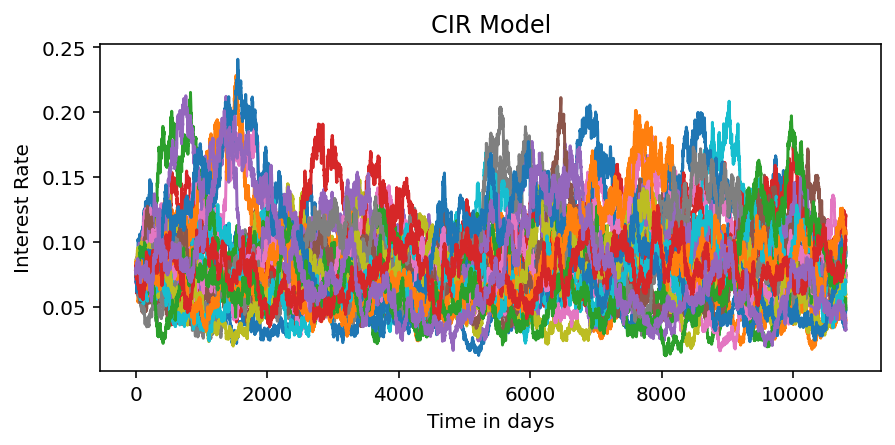

In [148]:
fig = plt.figure(figsize=(7, 3))
plt.plot(cir.T)
plt.xlabel("Time in days")
plt.ylabel("Interest Rate")
plt.title("CIR Model")
plt.show()

## L

In [149]:
import modules.L as L

In [150]:
wac = loan_df["Current_Interest_Rate"].mean()
notional = 100000

In [151]:
CPR = L.generate_CPR(wac, T, notional, r0, kappa, r_bar, sigma, simulations=500)

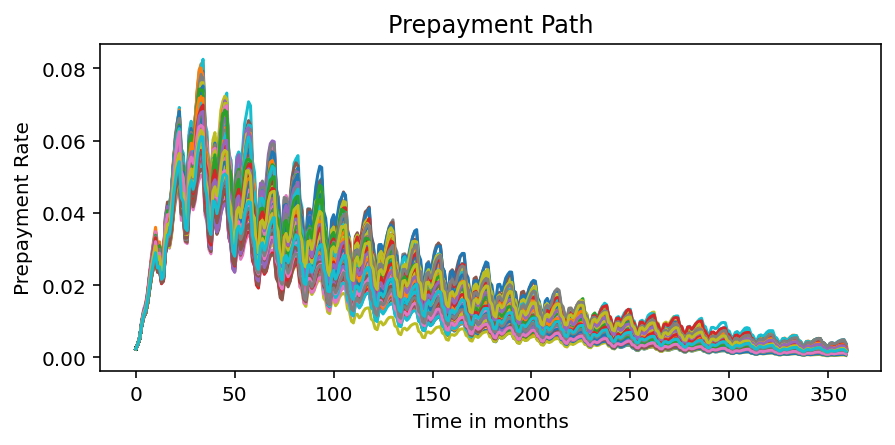

In [152]:
fig = plt.figure(figsize=(7, 3))
plt.plot(CPR.T)
plt.xlabel("Time in months")
plt.ylabel("Prepayment Rate")
plt.title("Prepayment Path")
plt.show()

## CF

In [111]:
import modules.CF as CF

In [112]:
discount_rate = 0.1
portfolio = CF.Loan_Portfolio(discount_rate, loan_df[:2])

Calculating Payments: 100%|██████████| 359/359 [00:56<00:00,  6.32it/s]


In [113]:
flows_aggregate = portfolio.cash_flows_aggregate_for_portfolio()

In [114]:
flow_tranchwise = portfolio.cash_flow_tranchwise(loan_df)

## A

In [137]:
import modules.A as A

In [138]:
price = A.MBS_pricing(portfolio, flows_aggregate, flow_tranchwise)

In [139]:
price.import_MBS_Cashflows()

In [141]:
price.caculate_tranch_value()

IndexError: arrays used as indices must be of integer (or boolean) type

In [142]:
price.plot_mbs_value()

AttributeError: 'MBS_pricing' object has no attribute 'npv_mbs_total'